In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from quetzal.model import stepmodel
import matplotlib.pyplot as plt

SQLalchemy is not installed. No support for SQL output.


In [3]:
# Load the model with LoS tables from the last exercise
model_path = '../../model/'
sm = stepmodel.read_json(model_path + 'los_tables')

## Step trip generation
In every zone we need to generate a column `emission` and `attraction`. What kind of trips you count to it largely affects the interpretability of your results. If you use employment characteristics only for attraction, your model will only be applicable to commuting questions, but not for shopping or leisure trips. Moreover, the results of a congestion analysis after the assignment step are worthless because the real network load is higher when you consider all demand segments.

In [4]:
# Lets see what data we have
sm.zones.sample()

,uuid,sch,nam,gdf,bezeich,pop,popCentroidLat,popCentroidLon,pois,poiCentroidLat,...,aquarium,attraction,camp_site,caravan_site,hostel,hotel,theme_park,zoo,lake,geometry
index,,,,,,,,,,,,,,,,,,,,,
zone_23,DEBE12YYJ000000L,110000121202,Tegel,33636381.0,AX_KommunalesGebiet,36774,52.583598,13.28618,502,52.58422,...,0,0,2,0,0,2,0,0,0,"POLYGON ((13.28884 52.62531, 13.28906 52.62484..."


In [5]:
# Start with emission and attraction from commuting purposes
# Assumptions (usually derived from a mobility survey):
employment_rate = 0.7
home_office_rate = 0.1
work_trips_per_day = 1.05 # we set up the model for one average weekday!
sm.zones['emission'] = sm.zones['pop'] * work_trips_per_day * (1-home_office_rate) * employment_rate
sm.zones['attraction'] = 0#sm.zones['emp']

In [6]:
# Now add the shopping purpose (usually derived from a mobility survey)
shopping_trips_per_day = 0.3
attraction_per_POI = sm.zones['pop'].mean() / sm.zones['pois'].mean() * shopping_trips_per_day
sm.zones['emission'] += sm.zones['pop'] * shopping_trips_per_day
sm.zones['attraction'] += sm.zones['pois'] * attraction_per_POI

Total emission: 3620092 Total attraction: 1129514


AttributeError: module 'matplotlib' has no attribute 'subplots'

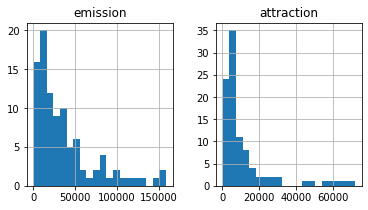

In [7]:
print('Total emission:', int(sum(sm.zones['emission'])), 'Total attraction:', int(sum(sm.zones['attraction'])))
sm.zones[['emission', 'attraction']].hist(bins=20, figsize=(6,3))
fig, ax = plt.subplots(2, 1, figsize=(16,16))
sm.zones.plot(ax=ax.flat[0], column='emission', cmap="Reds")
ax.flat[0].set_title("emission per zone")
sm.zones.plot(ax=ax.flat[1], column='attraction', cmap="Reds")
ax.flat[1].set_title("attraction per zone")


In [12]:
# Now we need to introduce our demand segments.
# Car owners and PT captives is a good start.
# Other common demand segments are trip purposes, income groups, age groups.
sm.segments = ['car_owner', 'pt_captive']
car_ownership = 0.4
sm.zones[('car_owner', 'emission')] = sm.zones['emission'] * car_ownership
sm.zones[('pt_captive', 'emission')] = sm.zones['emission'] * (1-car_ownership)
sm.zones[('car_owner', 'attraction')] = sm.zones['attraction'] * car_ownership
sm.zones[('pt_captive', 'attraction')] = sm.zones['attraction'] * (1-car_ownership)

In [13]:
# Cast columns to integer
sm.zones[('car_owner', 'emission')] = sm.zones[('car_owner', 'emission')].astype(int)
sm.zones[('car_owner', 'attraction')] = sm.zones[('car_owner', 'attraction')].astype(int)
sm.zones[('pt_captive', 'emission')] = sm.zones[('pt_captive', 'emission')].astype(int)
sm.zones[('pt_captive', 'attraction')] = sm.zones[('pt_captive', 'attraction')].astype(int)

In [14]:
# Delete the non-segmented columns to prevent errors
del sm.zones['emission']
del sm.zones['attraction']
sm.zones.sample()

,uuid,sch,nam,gdf,bezeich,pop,popCentroidLat,popCentroidLon,pois,poiCentroidLat,...,hostel,hotel,theme_park,zoo,lake,geometry,"(car_owner, emission)","(pt_captive, emission)","(car_owner, attraction)","(pt_captive, attraction)"
index,,,,,,,,,,,,,,,,,,,,,
zone_75,DEBE00YY2Ke00071,110000101004,Mahlsdorf,1.301659e+07,AX_KommunalesGebiet,29751,52.501904,13.616125,203,52.502923,...,0,2,0,0,0,"POLYGON ((13.63456 52.53048, 13.63468 52.53048...",11442,17163,2359,3538


## Step distribution

Once we have emission and attraction, we want to know the volumes per OD-pair. We can use the `step_distribution` function from quetzal. It uses the doubly constrained distribution (no probabilistic Logit approach), which is an iterative process where emissions and attractions are matched so that, on average, the minimal resistance for the whole system is found. Talking about resistance: an important input parameter is the impedance matrix, giving resistances between every OD-pair. Resistance can be time, but also cost or other utility/disutility quantifications.

Calibration of this step (not performed in this toy model) requires to change emission and attraction values or the impedance matrix

In [15]:
# Now, we need an impedance matrix for car and PT, respectively.
# Use time as resistance value, but distance or cost are thinkable, too
car_imp_matrix = sm.car_los[['origin', 'destination', 'time']].set_index(
    ['origin','destination']).unstack()
# Assign a resistance for staying in the home cell
car_imp_matrix = car_imp_matrix.replace(0, 120)

In [16]:
car_imp_matrix.head(3)

time                                                      \
destination       zone_0       zone_1      zone_10      zone_11      zone_12   
origin                                                                         
zone_0        120.000000   650.688234  1335.520518   885.740393  1306.403608   
zone_1        687.802030   120.000000  1364.670080   851.677938  1552.386470   
zone_10      1346.563514  1308.938322   120.000000  1081.542221  1160.476262   

                                                                              \
destination      zone_13      zone_14      zone_15      zone_16      zone_17   
origin                                                                         
zone_0        400.157480  1582.536164  1671.104582  2700.470272  1758.884850   
zone_1        938.157309  1749.596170  1819.316167  3132.618735  1974.454117   
zone_10      1505.481971   813.275554   758.740285  3031.790872  1213.858548   

             ...                                                      \
destination  ...      zone_88      zone_89       zone_9      zone_90   
origin       ...                                                       
zone_0       ...  1816.099193  1121.933411  1408.717787  1229.406994   
zone_1       ...  1845.248754   885.478113  1437.867348   970.909194   
zone_10      ...   880.717861  1408.449445   487.309162  1622.710285   

                                                                              \
destination      zone_91      zone_92      zone_93      zone_94      zone_95   
origin                                                                         
zone_0       1351.788812   892.884133  2046.582033  1399.377639  1760.246795   
zone_1       1667.130413   605.182547  2194.793619  1111.676053  1472.545210   
zone_10      2364.615713  1514.936324  1121.689967  1960.310892  2321.180049   

                          
destination      zone_96  
origin                    
zone_0       2462.483848  
zone_1       2914.739627  
zone_10      2874.301891  

[3 rows x 97 columns]

In [17]:
# In the PT case we have to take the minimum time per OD pair,
# because we have multiple routes
pt_imp_matrix = sm.pt_los.groupby(
    ['origin', 'destination']).agg({'time': 'min'}).unstack()

In [18]:
pt_imp_matrix = pt_imp_matrix.replace(0, 120)
pt_imp_matrix.head(3)

time                                                      \
destination       zone_0       zone_1      zone_10      zone_11      zone_12   
origin                                                                         
zone_0        120.000000  2265.809588  3255.574515  2723.579652  2978.384346   
zone_1       2217.619817   120.000000  2891.012506  1955.938100  2697.822338   
zone_10      3333.574515  3041.012506   120.000000  2625.091596  2780.694781   

                                                                              \
destination      zone_13      zone_14      zone_15      zone_16      zone_17   
origin                                                                         
zone_0       2016.654686  3435.335878  3748.872664  5643.300878  3790.608946   
zone_1       2187.520894  3154.773870  3468.310656  5252.476111  3510.046938   
zone_10      3210.094846  2697.646313  3125.183100  5795.539529  3592.919381   

             ...                                                      \
destination  ...      zone_88      zone_89       zone_9      zone_90   
origin       ...                                                       
zone_0       ...  4000.902173  3381.050918  3720.027611  3238.444192   
zone_1       ...  3720.340165  2223.672194  3439.465603  2094.850144   
zone_10      ...  2195.212608  3282.562862  1914.338046  3457.956136   

                                                                              \
destination      zone_91      zone_92      zone_93      zone_94      zone_95   
origin                                                                         
zone_0       2934.572667  2534.943577  4041.215118  3696.528138  3838.280255   
zone_1       3622.319684  1387.166490  3760.653110  2548.751051  2690.503169   
zone_10      4630.084611  3486.797746  3447.525553  4150.040081  4291.792199   

                          
destination      zone_96  
origin                    
zone_0       4468.378478  
zone_1       4893.363940  
zone_10      4986.117129  

[3 rows x 97 columns]

In [19]:
# We can perform the quetzal distribution function for all
# our demand segments simultaniously, saving us post-processing.
# Therefore, we need a dictionary with all parameters
distr_params = {'deterrence_matrix': {'car_owner': car_imp_matrix,
                                      'pt_captive': pt_imp_matrix}}
sm.step_distribution(segmented=True, **distr_params)

car_owner
pt_captive


In [20]:
sm.volumes.head(3)

,origin,destination,car_owner,pt_captive,all
0,zone_0,zone_0,4.303720,2.569058,6.872778
1,zone_0,zone_1,57.126872,136.449570,193.576442
2,zone_0,zone_2,15.824527,23.038191,38.862718


## Step mode choice

For mode choice we apply a nested logit model. In modeling terms, this step can be understood as the "logit" step, because the resulting utilities could also be used to compute the impedance matrix from above. You will see, that the logit step is entirely independent of the volumes and could, thus, be done earlier.

In [21]:
# First, we need parameters for our logit model.
# We define the nesting structure (i.e. choice tree)
# and the beta parameters which should come from a calibration
# using a mobility survey.
sm.preparation_logit(time=-0.00055, # beta_t
                     price=-1, # beta_p
                     transfers=0, # we don't want the number of transfers matter (even though it does sometimes)
                     mode=1, # theta_root
                     pt_mode=0.5, # theta_pt (nest parameter for PT)
                     pt_path=0.1, # theta_path (nest parameter for different paths of one PT option)
                     segments=sm.segments
)
# For nest parameters you should take 1 >= mode >= pt_mode >= pt_path > 0

In [22]:
# Now we have generated the nesting structure table
# Can differ by demand segment, if you want
sm.mode_nests

segment,root,car_owner,pt_captive
route_type,,,
bus,pt,pt,pt
root,NaN,NaN,NaN
rail,pt,pt,pt
walk,root,root,root
subway,pt,pt,pt
car,root,root,root
tram,pt,pt,pt
pt,root,root,root


In [23]:
# And the corresponding theta values
sm.logit_scales

segment,root,car_owner,pt_captive
route_type,,,
bus,0.1,0.1,0.1
root,1.0,1.0,1.0
rail,0.1,0.1,0.1
walk,0.0,0.0,0.0
subway,0.1,0.1,0.1
car,0.0,0.0,0.0
tram,0.1,0.1,0.1
pt,0.5,0.5,0.5


In [24]:
# And the Alternative-Specific-Constants (ASC)
# We have to prevent PT captives from using a car
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100
sm.mode_utility

segment,root,car_owner,pt_captive
route_type,,,
bus,0,0,0
root,0,0,0
rail,0,0,0
walk,0,0,0
subway,0,0,0
car,0,0,-100
tram,0,0,0


In [25]:
# And the beta parameters
# The column 'mode_utility' refers to the weight of the ASC table
# Delete the transfers attribute because we don't want it in our model formulation
sm.utility_values.drop('ntransfers', inplace=True)
sm.utility_values

segment,root,car_owner,pt_captive
value,,,
time,-0.00055,-0.00055,-0.00055
price,-1.00000,-1.00000,-1.00000
mode_utility,1.00000,1.00000,1.00000


In [26]:
# Now, add segment specific ASC column to LoS table.
# But first we have to generate a combined LoS table
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['route_types'] = sm.los['route_types'].apply(tuple)# bugfix
sm.analysis_mode_utility(how='main', # how refers to how to calculate the ASC from multiple paths
                         segment=None) # automatically iterates through segments

100%|██████████| 2/2 [00:00<00:00, 23.54it/s]


In [27]:
# Finally, run the logit model
sm.initialize_logit()
# If you want to know what parameters you can give to the function,
# look into the code. You can find the most important functions in
# the quetzal/model/transportmodel.py file, which refers to sub-functions
# by importing them from other quetzal files
sm.step_logit()

100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


In [28]:
# The result is a utilities table
sm.utilities.head(3)

route_type,origin,destination,segment,root,car,walk,pt,tram,subway,rail,bus
0,zone_0,zone_0,car_owner,0.023245,0.000000,-inf,-3.750000,-inf,-inf,-inf,-3.750000
1,zone_0,zone_0,pt_captive,-3.750000,-100.000000,-inf,-3.750000,-inf,-inf,-inf,-3.750000
2,zone_0,zone_1,car_owner,-1.035310,-1.064546,-inf,-4.582257,-inf,-6.933688,-4.926881,-4.939976


In [29]:
# and the probabilities
sm.probabilities.head(3)

route_type,origin,destination,segment,root,car,walk,pt,tram,subway,rail,bus
0,zone_0,zone_0,car_owner,1,9.770226e-01,0.0,0.022977,0.0,0.000000,0.000000,0.022977
1,zone_0,zone_0,pt_captive,1,1.581817e-42,0.0,1.000000,0.0,0.000000,0.000000,1.000000
2,zone_0,zone_1,car_owner,1,9.711875e-01,0.0,0.028812,0.0,0.000261,0.014463,0.014089


In [30]:
# Moreover, you have now probabilities assigned to your paths!
sm.los.head(3)

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,access_length,footpath_length,in_vehicle_length,length,price,mode_utility,"(car_owner, utility)","(pt_captive, utility)","(car_owner, probability)","(pt_captive, probability)"
0,zone_0,zone_0,0.00000,[zone_0],False,mode_breaker,"[bus, rail, tram, subway]",[],[],[],...,0.000000,0.00000,0.0,0.000000,3.75,0,-3.750000,-3.750000,2.297737e-02,1.00000
1,zone_0,zone_35,2994.30472,"[zone_0, n_665, n_623, n_228, zone_35]",False,mode_breaker,"[bus, rail, tram, subway]",[],[],"[n_665, n_623, n_228]",...,1803.419857,1633.32228,0.0,3436.742138,3.75,0,-5.396868,-5.396868,9.504112e-07,0.00004
2,zone_1,zone_1,0.00000,[zone_1],False,mode_breaker,"[bus, rail, tram, subway]",[],[],[],...,0.000000,0.00000,0.0,0.000000,3.75,0,-3.750000,-3.750000,2.297737e-02,1.00000


## Step assignment

This step combines the path probabilities with the volumes and loads them onto the networks.

In [31]:
sm.volumes.head(2)

,origin,destination,car_owner,pt_captive,all
0,zone_0,zone_0,4.303720,2.569058,6.872778
1,zone_0,zone_1,57.126872,136.449570,193.576442


In [32]:
# We want to do an assignment for cars and PT seperately
# (although there is a wrapper function in quetzal)
# Therefore, we must transfer the path probabilities to pt_los and car_los
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']

In [33]:
# PT first
sm.segmented_pt_assignment(split_by='route_type', # identify from which route type the load comes
                           on_road_links=False, # load bus traffic to the road network (requires casted networks)
                           path_column='link_path' # pt_los column with the path list
                          )

pt_captive: 100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


In [34]:
# Now cars
sm.segmented_car_assignment()

pt_captive: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


In [35]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,...,origin,destination,geometry,road_node_list,road_link_list,"(load, bus)","(load, tram)","(load, subway)","(load, rail)",load
index,,,,,,,,,,,,,,,,,,,,,
link_2133,17304_700_5,n_563,n_174,11,60.0,1200,17304_700_5,17304_700,153,0,...,n_563,n_174,"LINESTRING (13.30270 52.53692, 13.30282 52.536...","[27008019, 29024611, 26790038, 26750531, 26750...","[84484, 78106, 77219, 5278, 5280, 6220, 6221, ...",570.140966,255.927631,0.0,2.022405,828.091002


In [36]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

,a,b,length,time,walk_time,geometry,highway,maxspeed,"(car_owner, car)","(pt_captive, car)","(all, car)"
index,,,,,,,,,,,
813,21508603,726624835,396.785,29.59885,88.796549,"LINESTRING (13.40215 52.60285, 13.40014 52.60621)",primary,"[30, 50, 70]",607.802323,9.675064e-40,607.802323


<AxesSubplot:>

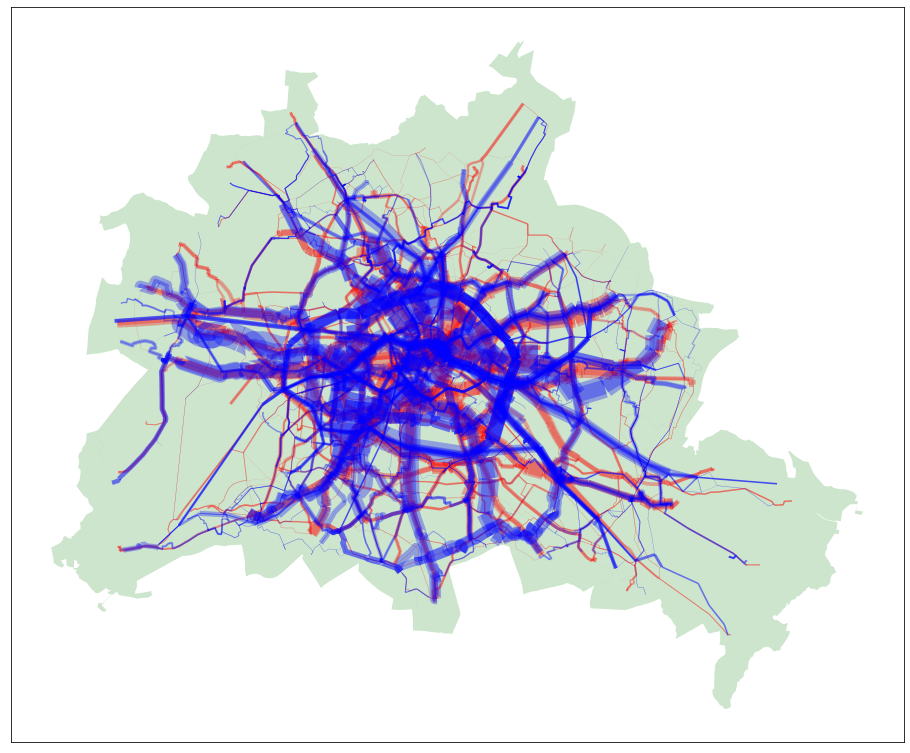

In [37]:
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / 35
sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
        ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))

In [38]:
# Summary of LoS table using a quetzal function
# All attributes are multiplied with path probabilities
od_sum = sm.summary_od(costs=['price', # EUR per person
                              'time', # seconds per ride
                              'in_vehicle_time', # seconds per ride
                              'length', # Meter distance
                              'ntransfers']) # per ride

In [39]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[(seg, 'length')] / 1000
    # Adjust units of other indicators
    od_sum[(seg, 'in_vehicle_time')] = od_sum[(seg, 'in_vehicle_time')] / 3600
    od_sum[(seg, 'time')] = od_sum[(seg, 'time')] / 3600
    od_sum[(seg, 'length')] = od_sum[(seg, 'length')] / 1000

In [40]:
od_sum.sample(3)

segment                       car_owner                                      \
sum                              volume     price      time in_vehicle_time   
origin  destination mode                                                      
zone_71 zone_7      subway     0.151228  0.059487  0.015667        0.010014   
zone_87 zone_34     rail       0.333952  0.085404  0.019834        0.009707   
zone_77 zone_45     car     1693.944464  1.493863  0.277136        0.000000   

segment                                             pt_captive                \
sum                            length ntransfers        volume         price   
origin  destination mode                                                       
zone_71 zone_7      subway   0.454430   0.023795  3.813873e+00  8.566907e-01   
zone_87 zone_34     rail     0.630573   0.051205  1.496614e+01  2.066841e+00   
zone_77 zone_45     car     12.448857   0.000000  3.903819e-39  2.604476e-42   

segment                                                   ...             \
sum                                 time in_vehicle_time  ... ntransfers   
origin  destination mode                                  ...              
zone_71 zone_7      subway  2.256266e-01        0.144210  ...   0.342677   
zone_87 zone_34     rail    4.799974e-01        0.234911  ...   1.239200   
zone_77 zone_45     car     4.831734e-43        0.000000  ...   0.000000   

segment                            root                                      \
sum                              volume     price      time in_vehicle_time   
origin  destination mode                                                      
zone_71 zone_7      subway     3.965101  0.826285  0.217619        0.139091   
zone_87 zone_34     rail      15.300088  2.023593  0.469953        0.229995   
zone_77 zone_45     car     1693.944464  1.493863  0.277136        0.000000   

segment                                              car_owner    pt_captive  \
sum                            length ntransfers           pkm           pkm   
origin  destination mode                                                       
zone_71 zone_7      subway   6.312079   0.330515      0.068723  2.495931e+01   
zone_87 zone_34     rail    14.941046   1.213270      0.210581  2.283887e+02   
zone_77 zone_45     car     12.448857   0.000000  21087.672356  8.472835e-80   

segment                             root  
sum                                  pkm  
origin  destination mode                  
zone_71 zone_7      subway     25.028035  
zone_87 zone_34     rail      228.599322  
zone_77 zone_45     car     21087.672356  

[3 rows x 21 columns]

array([<AxesSubplot:ylabel='(car_owner, volume)'>,
       <AxesSubplot:ylabel='(pt_captive, volume)'>], dtype=object)

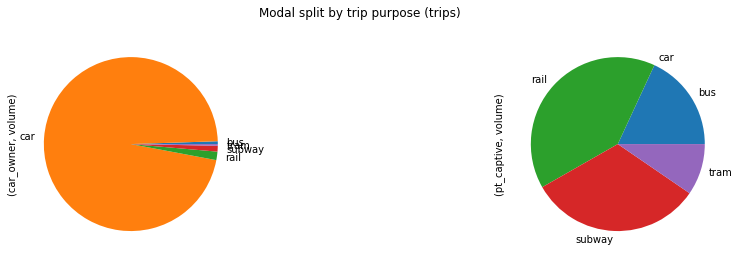

In [41]:
od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')

array([<AxesSubplot:ylabel='(car_owner, pkm)'>,
       <AxesSubplot:ylabel='(pt_captive, pkm)'>], dtype=object)

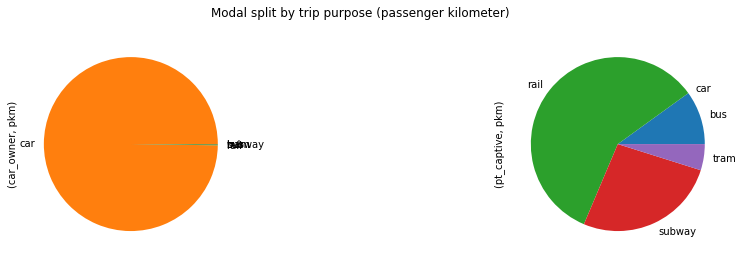

In [42]:
od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

## Save model

In [44]:
# Save the od_sum as Excel
with pd.ExcelWriter('../../outputs/od_summary.xlsx') as writer:  
    od_sum.to_excel(writer, sheet_name='od_sum')

In [45]:
# make sure that all tables have unique indicies before saving
sm.probabilities.reset_index(inplace=True, drop=True)
sm.utilities.reset_index(inplace=True, drop=True)

In [46]:
sm.to_json(model_path + 'four_steps')

to_hdf(overwriting):  60%|██████    | 27/45 [01:40<00:26,  1.47s/it]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes


to_hdf(overwriting): 100%|██████████| 45/45 [01:47<00:00,  2.39s/it]

could not save attribute: parameters
